# HARK and SSJ example

By William Du (wdu9@jhu.edu) 


- This notebook demonstrates how HARK and the Sequence Space Jacobian toolkit can be combined to solve HANK models.
    - And is heavily drawn from this [SSJ notebook](https://github.com/shade-econ/nber-workshop-2022/blob/main/Tutorials/Tutorial%201%20Fiscal%20Policy.ipynb) .

 <br />

 
- HARK was designed to solve rich microeconomic models:
    - Lifecycle models
    - Discrete continuous choice
    - Portfolio choice. 
    
<br />

- SSJ was created to solve HANK models with incredibly speed and ease

- Connecting HARK to SSJ allows us to solve macro models with richer micro features.


# Model


To begin a basic HANK model is introduced. The model follows these lecture [SSJ slides](https://github.com/shade-econ/nber-workshop-2022/blob/main/Lectures/Lecture%204%20Fiscal%20Policy.pdf) from their heterogeneous agent workshop.


- Heterogenous agent households that consume/save into one asset. 

- Households face idiosyncratic income shocks.

- Cobb Douglas Production function with Labor.

- Sticky Wages

- Government taxes labor income, rolls over debt, to pay its expenditures.


# Bringing Model to Code

In [1]:
from HARK.ConsumptionSaving.ConsNewKeynesianModel import (
    NewKeynesianConsumerType,
)

from sequence_jacobian.classes import JacobianDict, SteadyStateDict
import sequence_jacobian as sj  # SSJ will allow us to define blocks, models, compute IRFs, etc

In [2]:
import matplotlib.pyplot as plt
import numpy as np  # '1.22.0'
import time
from scipy import optimize  # scipy version '1.10.0'

### Calibrate Steady State Values

In [3]:
# Steady state parameters
r_ss = 0.03  # Interest rate
G_ss = 0.2  # government spending
B_ss = 0.2  # government debt
Y_ss = 1.0  # output

T_ss = G_ss + r_ss * B_ss  # Lump sum taxes
Z_ss = Y_ss - T_ss  # after tax labor income
deficit_ss = G_ss - T_ss  # deficit

In [4]:
HANK_dict = {
    "cycles": 0,  # Infinite horizon problem
    # Parameters shared with the perfect foresight model
    "Rfree": 1.0 + r_ss,  # Interest factor on assets
    "LivPrb": [0.99375],  # Survival probability
    # Parameters that specify the income distribution over the lifecycle
    "PermShkStd": [0.06],  # Standard deviation of log permanent shocks to income
    "PermShkCount": 5,  # Number of points in discrete approximation to permanent income shocks
    "TranShkStd": [0.2],  # Standard deviation of log transitory shocks to income
    "TranShkCount": 5,  # Number of points in discrete approximation to transitory income shocks
    # HANK parameters
    "tax_rate": [
        0.0
    ],  # set to 0.0 because we are going to assume that labor here is actually after tax income
    "labor": [Z_ss],
    "wage": [1.0],
    "UnempPrb": 0.0,  # Probability of unemployment while working
    "IncUnemp": 0.0,  # Unemployment benefits replacement rate
    # Parameters for constructing the "assets above minimum" grid
    "aXtraMax": 50,  # Maximum end-of-period "assets above minimum" value
    "aXtraCount": 100,  # Number of points in the base grid of "assets above minimum"
    "BoroCnstArt": 0.0,
    # Transition matrix simulation parameters
    "mCount": 200,
    "mMax": 50,
    "mMin": 1e-5,
    "mFac": 3,
}

# Solve for Steady State

In [5]:
def ss_func(beta):
    HANK_dict["DiscFac"] = beta
    TempAgent = NewKeynesianConsumerType(**HANK_dict, verbose=False)
    A_ss = TempAgent.compute_steady_state()[0]
    return A_ss


def ss_dif(beta):
    return ss_func(beta) - Asset_target


Asset_target = B_ss
DiscFac = optimize.brentq(ss_dif, 0.85, 0.99)

In [6]:
# Create a HARK agent
HANK_dict["DiscFac"] = DiscFac
Agent_GE = NewKeynesianConsumerType(**HANK_dict, verbose=False)
A_ss, C_ss = Agent_GE.compute_steady_state()

In [7]:
print("goods_clearing", Y_ss - C_ss - G_ss)
print("asset_clearing", A_ss - B_ss)

goods_clearing 5.6066262743570405e-15
asset_clearing -4.707345624410664e-14


## Compute Jacobians

In [8]:
start = time.time()

CJACR, AJACR = Agent_GE.calc_jacobian("Rfree", 300)
CJACZ, AJACZ = Agent_GE.calc_jacobian("labor", 300)

print("Time taken to compute jacobians", time.time() - start)

Time taken to compute jacobians 3.3388569355010986


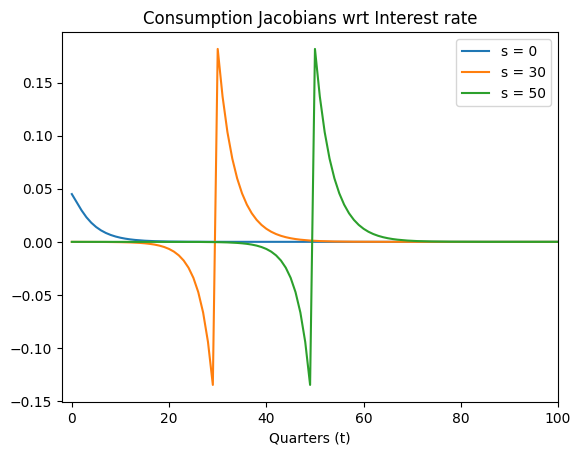

In [9]:
plt.plot(CJACR.T[0], label = 's = 0')
plt.plot(CJACR.T[30], label = 's = 30')
plt.plot(CJACR.T[50], label = 's = 50')
plt.xlim(-2, 100)
plt.title("Consumption Jacobians wrt Interest rate")
plt.xlabel('Quarters (t)')
plt.legend()
plt.show()

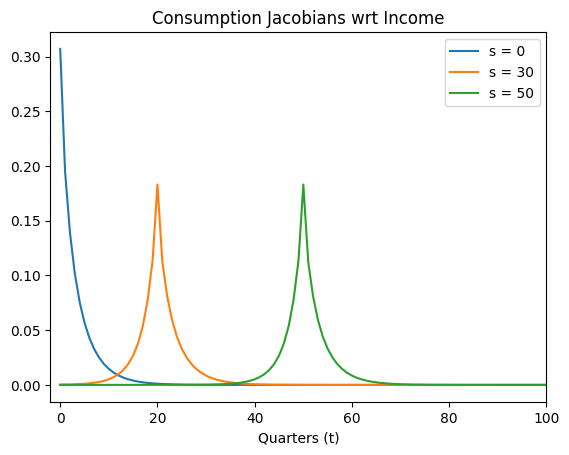

In [10]:
plt.plot(CJACZ.T[0], label = 's = 0')
plt.plot(CJACZ.T[20], label = 's = 30')
plt.plot(CJACZ.T[50], label = 's = 50')
plt.xlim(-2, 100)
plt.title("Consumption Jacobians wrt Income")
plt.xlabel('Quarters (t)')
plt.legend()
plt.show()

# Specify Government Budget Constraint and Market Clearing Conditions

In [11]:
# Government Budget Constraint
@sj.simple
def fiscal(B, r, G, Y):
    T = (1 + r) * B(-1) + G - B  # total tax burden
    Z = Y - T  # after tax income
    deficit = G - T
    return T, Z, deficit


# Market Clearing Conditions
@sj.simple
def mkt_clearing(A, B, Y, C, G):
    asset_mkt = A - B
    goods_mkt = Y - C - G
    return asset_mkt, goods_mkt

In [12]:
# Store Jacobians in JacobianDict Object
Jacobian_dict = JacobianDict({"C": {"Z": CJACZ}, "A": {"Z": AJACZ}})

In [13]:
# Construct SteadyStateDict object
SteadyState_dict = SteadyStateDict(
    {
        "asset_mkt": 0.0,
        "goods_mkt": 0.0,
        "deficit": G_ss - T_ss,
        "B": B_ss,  # Gov. Debt
        "r": r_ss,  # Interest rate
        "G": G_ss,  # Gov. Spending
        "Y": Y_ss,  # Output
        "A": B_ss,  # Assets
        "C": C_ss,  # Consumption
        "Z": Y_ss - T_ss,  # Income (post-tax)
        "T": T_ss,  # Lump Sum Taxes
    }
)

In [14]:
T = 300  # <-- the length of the IRF
rho_G = 0.8  # peristence of shock
dG = 0.01 * rho_G ** np.arange(T)
shocks = {"G": dG}

unknowns_td = ["Y"]
targets_td = ["asset_mkt"]

# Create model
ha_lin = sj.create_model([Jacobian_dict, fiscal, mkt_clearing], name="HA Model")

# obtain impulse responses
irfs_G_lin = ha_lin.solve_impulse_linear(
    SteadyState_dict, unknowns_td, targets_td, shocks
)

In [15]:
def show_irfs(
    irfs_list,
    variables,
    labels=[" "],
    ylabel=r"Percentage points (dev. from ss)",
    T_plot=50,
    figsize=(18, 6),
):
    if len(irfs_list) != len(labels):
        labels = [" "] * len(irfs_list)
    n_var = len(variables)
    fig, ax = plt.subplots(1, n_var, figsize=figsize, sharex=True)
    for i in range(n_var):
        # plot all irfs
        for j, irf in enumerate(irfs_list):
            ax[i].plot(irf[variables[i]][:50], label=labels[j])
        ax[i].set_title(variables[i])
        ax[i].set_xlabel(r"$t$")
        if i == 0:
            ax[i].set_ylabel(ylabel)
        ax[i].legend()
    plt.show()

## Government Spending Shock (Balanced Budget)

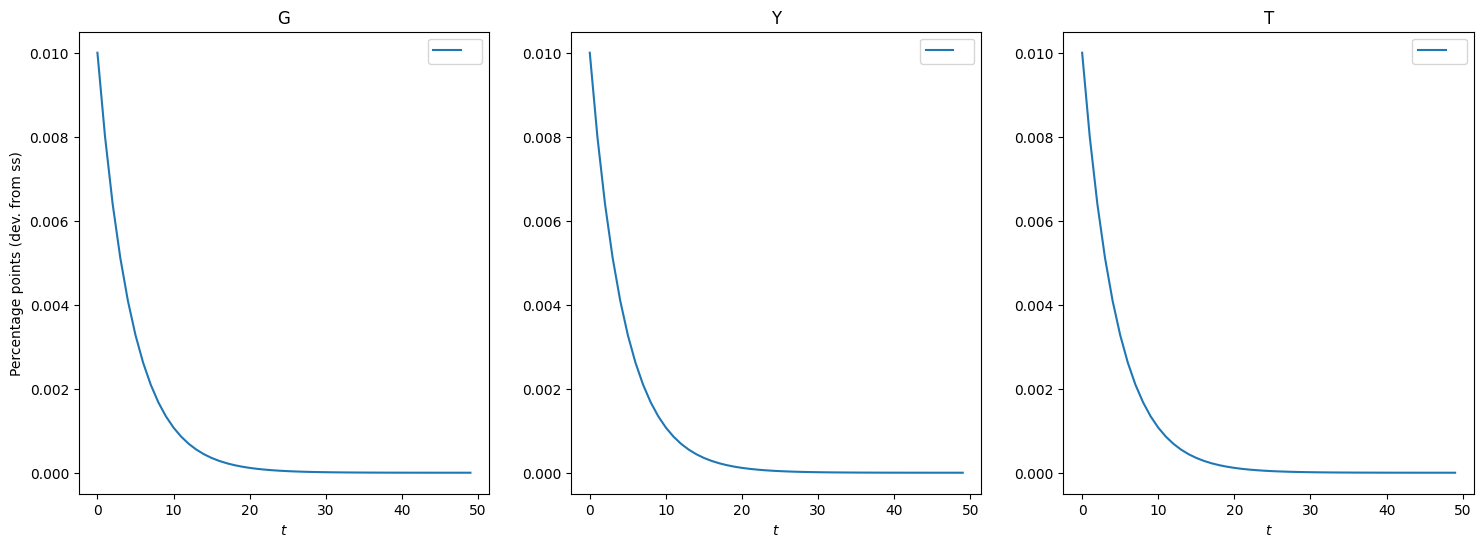

In [16]:
show_irfs([irfs_G_lin], ["G", "Y", "T"])

## Government Spending shock (deficit financed)

In [17]:
rho_B = 0.9
dB = np.cumsum(dG) * rho_B ** np.arange(T)
shocks_B = {"G": dG, "B": dB}

irfs_B_lin = ha_lin.solve_impulse_linear(
    SteadyState_dict, unknowns_td, targets_td, shocks_B
)

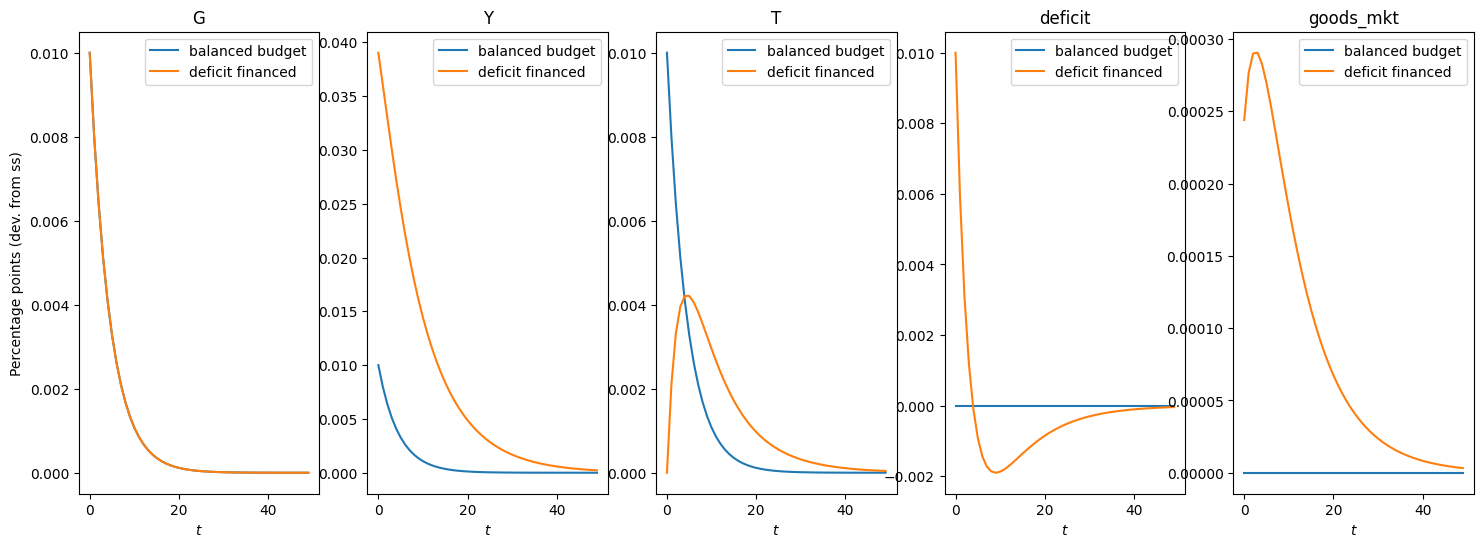

In [18]:
show_irfs(
    [irfs_G_lin, irfs_B_lin],
    ["G", "Y", "T", "deficit", "goods_mkt"],
    labels=["balanced budget", "deficit financed"],
)

## Nonlinear Impulse Responses

In [19]:
# NOTE: These cells have been commented out because they rely on files that are not present in the HARK repo.

# def hh(Z):
#    C,A = Agent_GE.calc_agg_path(Z,300)
#    return C,A

In [20]:
# from Misc_Utilities.simple_block import exog # import wrapper so SSJ can identify HARK household object

# hh_block = exog(Jacobian_dict,hh,hh)
# hh_block.name = hh

# ha = sj.create_model([hh_block,fiscal,mkt_clearing], name="HA Model")
# irfs_G_nonlin = ha.solve_impulse_nonlinear(SteadyState_dict, unknowns_td, targets_td, shocks)


In [21]:
# plt.plot(irfs_G_nonlin['Y'], label ='nonlinear')
# plt.plot(irfs_G_lin['Y'], label = 'linear', linestyle='--')
# plt.xlim(-1,50)
# plt.legend()
# plt.title('Nonlinear Impulse responses of output')
# plt.show()

In [22]:
# show_irfs([irfs_G_lin,irfs_G_nonlin], ['G', 'Y','T'], ['Linear', 'Nonlinear'])

# Why does HANK matter?

Let us compare HANK vs TANK vs RANK.

In this section we will define household blocks for a representative agent and a two agent. 



## Specify a representative agent household

In [23]:

@sj.solved(unknowns={'C': 1, 'A': 1},
           targets=["euler", "budget_constraint"])  # solver="broyden_custom")
def hh_ra(C, A, Z, eis, beta, r):
    euler = (beta * (1 + r(+1)))**(-eis) * C(+1) - C
    budget_constraint = (1 + r) * A(-1) + Z - C - A
    MPC = 0
    return euler, budget_constraint, MPC

ra = sj.create_model([hh_ra, fiscal, mkt_clearing], name="Representative agent model")



## Specify a two agent household

In [24]:
@sj.solved(unknowns={'C_RA': 1, 'A': 1},
           targets=["euler", "budget_constraint"])  # , solver="broyden_custom")
def hh_ta(C_RA, A, Z, eis, beta, r, lam):
    euler = (beta * (1 + r(+1))) ** (-eis) * C_RA(+1) - C_RA      # consumption of infinitely lived household
    C_H2M = Z   # computes consumption of an hand to mouth agent
    C = (1 - lam) * C_RA + lam * C_H2M
    budget_constraint = (1 + r) * A(-1) + Z - C - A
    MPC = 0
    return euler, budget_constraint, C_H2M, C, MPC

ta = sj.create_model([hh_ta, fiscal, mkt_clearing], name="Two agent model")

## Calibrate and find steady states of TANK and RANK models.

In [25]:
calibration = {'eis': 0.5,  # EIS
               'G': G_ss,  # Government spending
               'B': B_ss,  # Government debt
               'Y': Y_ss,  # Output
              'r': r_ss,}  # Number of productivity grid points


In [26]:
calibration_ra = calibration.copy()
calibration_ra['beta'] = 1 / (1 + calibration_ra['r'])
calibration_ra['B'] = calibration['B']

unknowns_ra_ss = {'C': 1., 'A': 0.8}
targets_ra_ss = {'budget_constraint': 0., 'asset_mkt': 0.}

ss_ra = ra.solve_steady_state(calibration_ra, unknowns_ra_ss, targets_ra_ss, dissolve=['hh_ra'])

In [27]:
calibration_ta = calibration_ra.copy()
calibration_ta['lam'] = 0.25
unknowns_ta_ss = {'C_RA': 1., 'A': 0.8}

ss_ta = ta.solve_steady_state(calibration_ta, unknowns_ta_ss, targets_ra_ss, dissolve=['hh_ta'])

## Impulse responses to deficit financed G shocks: HANK vs TANK vs RANK

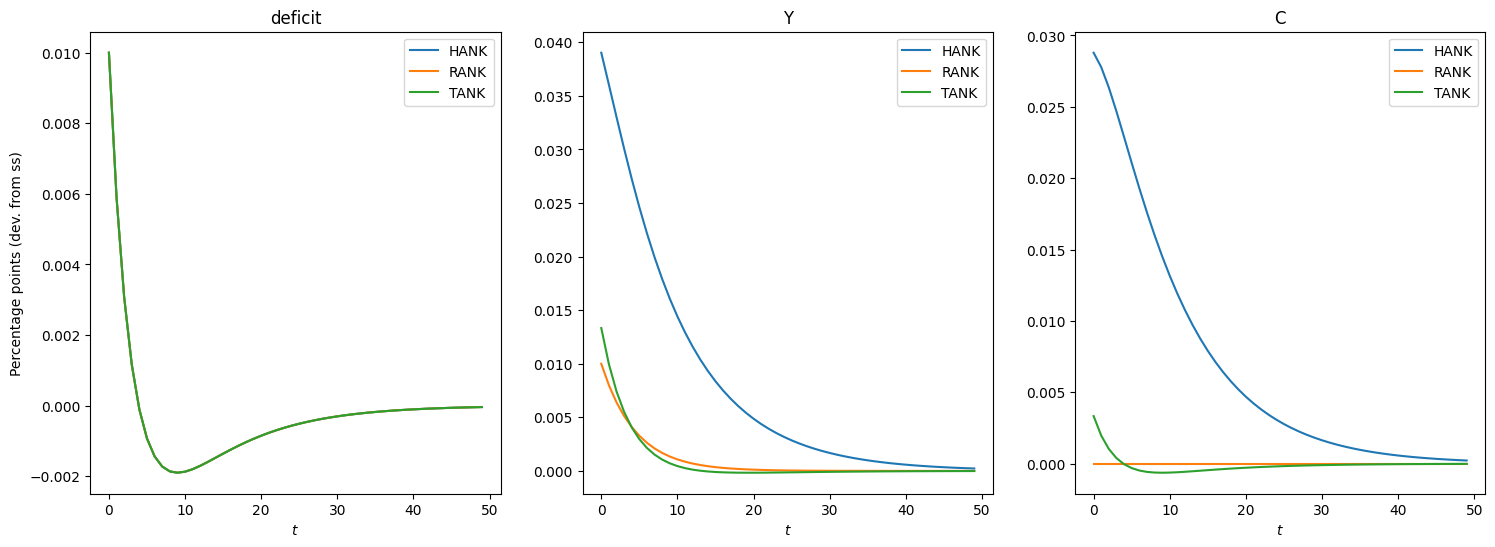

In [28]:
irfs_ra = ra.solve_impulse_linear(ss_ra, unknowns_td, targets_td, shocks_B)
irfs_ta = ta.solve_impulse_linear(ss_ta, unknowns_td, targets_td, shocks_B)
show_irfs([irfs_B_lin, irfs_ra, irfs_ta], variables=['deficit', 'Y', 'C'], labels=['HANK', 'RANK', 'TANK'])

# Simulating time series

## Let us simulate the economy when it is subject to deficit financed government spending shocks.

In [33]:
from estimation.plots import plot_timeseries
from estimation.routines import simulate


outputs = ['Y', 'C', 'deficit','G'] # variables to be simulated

impulses_ha = {}
impulses_ra = {}
impulses_ta = {}

shk_std = .001 # standard deviation of shock
rho_G = .8 # persistence of G shock
rho_B = 0.9 # persistence of Deficit shock 

dG = shk_std * .8 ** np.arange(T) # G Shock series
dB = np.cumsum(dG) * rho_B ** np.arange(T) # deficit shock series

own_shock = {"G": shk_std * rho_G ** np.arange(T) ,"B": dB }
impulses_ha['ha'] = ha_lin.solve_impulse_linear(SteadyState_dict, unknowns_td, targets_td, own_shock)
impulses_ta['ta'] = ta.solve_impulse_linear(ss_ta, unknowns_td, targets_td, own_shock)
impulses_ra['ra'] = ra.solve_impulse_linear(ss_ra, unknowns_td, targets_td, own_shock)


T_sim = 80  # simulate for 80 quarters
data_simul_ha = simulate(list(impulses_ha.values()), outputs, T_sim)
data_simul_ta = simulate(list(impulses_ta.values()), outputs, T_sim)
data_simul_ra = simulate(list(impulses_ra.values()), outputs, T_sim)


# Comparing time series of HANK, TANK, and RANK

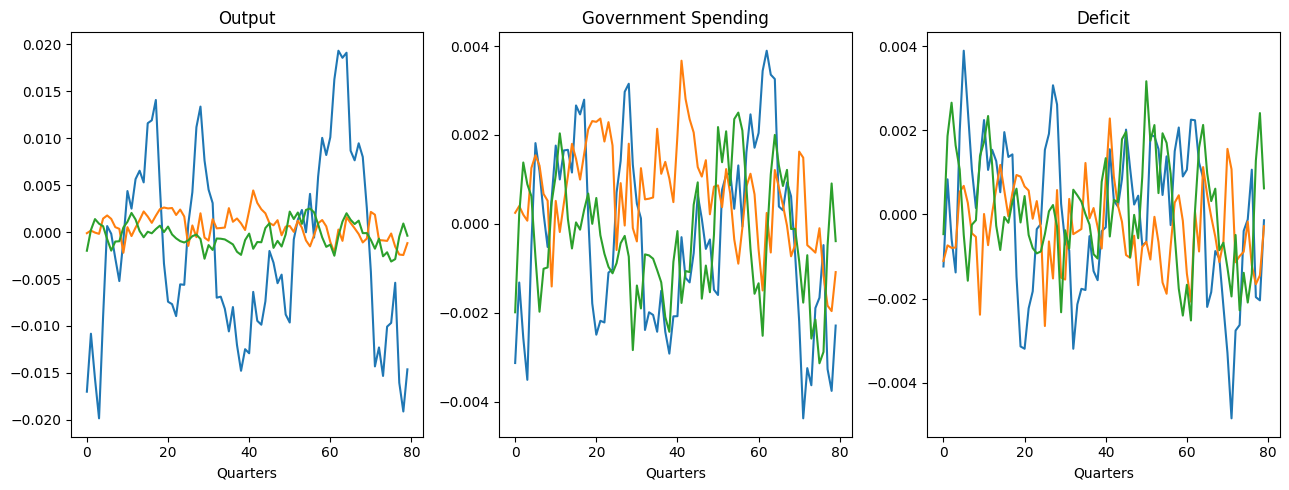

In [34]:

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(13, 5))
axes[0].plot(data_simul_ha['Y'])
axes[0].plot(data_simul_ta['Y'])
axes[0].plot(data_simul_ra['Y'])
axes[0].set_title('Output')
axes[0].set_xlabel('Quarters')
axes[1].plot(data_simul_ha['G'])
axes[1].plot(data_simul_ta['G'])
axes[1].plot(data_simul_ra['G'])
axes[1].set_title('Government Spending')
axes[1].set_xlabel('Quarters')
axes[2].plot(data_simul_ha['deficit'])
axes[2].plot(data_simul_ta['deficit'])
axes[2].plot(data_simul_ra['deficit'])
axes[2].set_title('Deficit')
axes[2].set_xlabel('Quarters')
fig.tight_layout()